# Análisis de los datos de aceleración

En este _notebook_ se presenta un análisis de los de la aceleración medida en la boya. En la primera parte se hace un análisis de los rasgos más característicos del espectro de la aceleración vertical medida por el `ekinox`, luego se presentan las señales en el tiempo y por último se hace se analiza la sensibilidad de los datos a la frecuencia de corte usadad para la intergración.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import netCDF4 as nc
import datetime as dt
import scipy.signal as signal
#
from src.processing.read_raw_data import ReadRawData
from src.processing import motion_correction as motcor
#
%matplotlib inline

## Espectros de la aceleración vertical

En esta primera parte se define una función para que genere el espectro de potencia de la señal de la aceleración vertical (líneas de colores) medida con el `ekinox` de intervalos de 10 minutos correspondientes a 10 fechas escogidas aleatoriamente en dentro del rango de medición de cada boya. El promedio de todos los casos se muestra en color negro. Los espectros son obtenidos usando el períodograma de Welch.

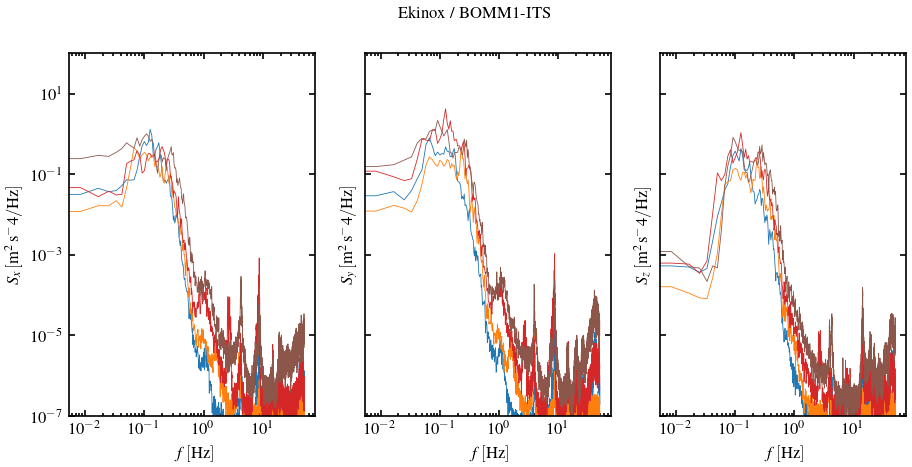

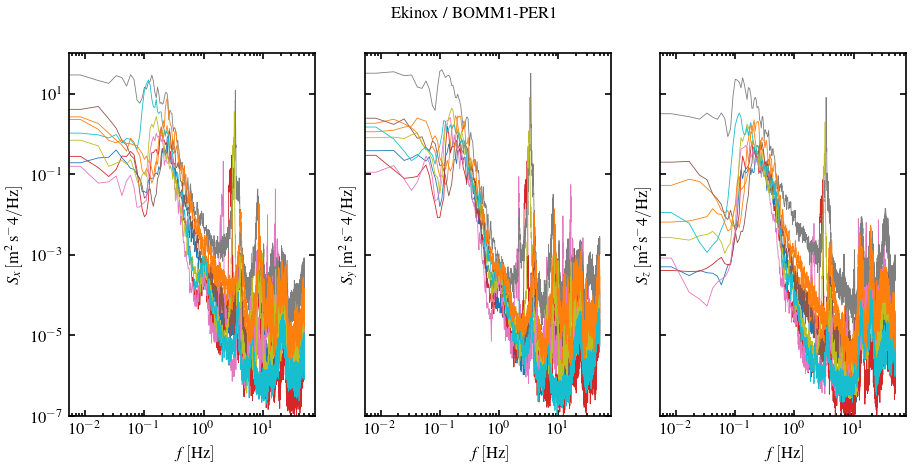

In [2]:
def random_acceleration_spectra(metafile, N=10):
    """Plots N random spectra for vertical aceleration"""

    r = ReadRawData(metafile)
    start = dt.datetime.strptime(r.metadata["t_ini"], "%Y-%m-%d")
    final = dt.datetime.strptime(r.metadata["t_fin"], "%Y-%m-%d")

    fig, ax = plt.subplots(1, 3, figsize=(9,4), sharex=True, sharey=True, dpi=120)
    offset = 1
    
    for i in range(N):
        delta = int((final - start).total_seconds() / 3600)
        date = start + dt.timedelta(hours=np.random.randint(0, delta))
        try:
            ekx = r.ekinox(date)
            frq, Px = signal.welch(ekx["accel_x"], fs=100, nperseg=len(ekx["time"])/5)
            frq, Py = signal.welch(ekx["accel_y"], fs=100, nperseg=len(ekx["time"])/5)
            frq, Pz = signal.welch(ekx["accel_z"], fs=100, nperseg=len(ekx["time"])/5)
            ax[0].loglog(frq, Px * offset, lw=0.5)
            ax[1].loglog(frq, Py * offset, lw=0.5)
            ax[2].loglog(frq, Pz * offset, lw=0.5)
            offset += 1
        except:
            pass

    labels = ["x", "y", "z"]
    for j in range(3):
        ax[j].set_ylim((1E-7, 1E2))
        ax[j].set_xlabel("$f\,\mathrm{[Hz]}$")
        ax[j].set_ylabel(f"$S_{{{labels[j]}}}\,\mathrm{{[m^2\,s^{-4}/Hz]}}$")
    
    fig.suptitle(f"Ekinox / {r.metadata['name'].replace('_', '-').upper()}")

random_acceleration_spectra("../metadata/bomm1_its.yml", N=10)
random_acceleration_spectra("../metadata/bomm1_per1.yml", N=10)

Se hace una comparación de los datos de la BOMM1 instalada cerca de la Isla Todos Santos y la BOMM1 instlada en Perdido (Golfo de México). En ambos casos se observa una serie de picos en frecuencias altas ($f>1\,\mathrm{Hz}$), los dos más notorios se encuentra alrededor de $4\,\mathrm{Hz}$ y entre $10\,\mathrm{Hz}$ y $20\,\mathrm{Hz}$. Estos picos pueden deberse a modos de vibración de la estructura de la boya. Se observa también que en el caso de la BOMM1-ITS, la zona del espectro que corresponde a las frecuencias asociadas con el oleje, es más ancha en comparación con los datos de la BOMM1-PER.

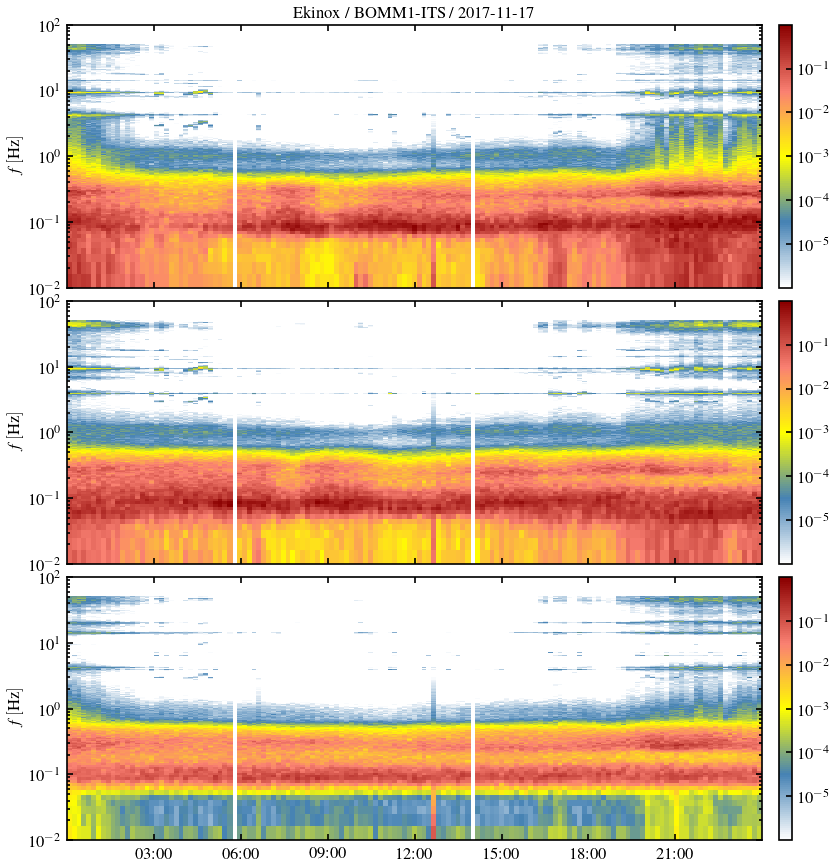

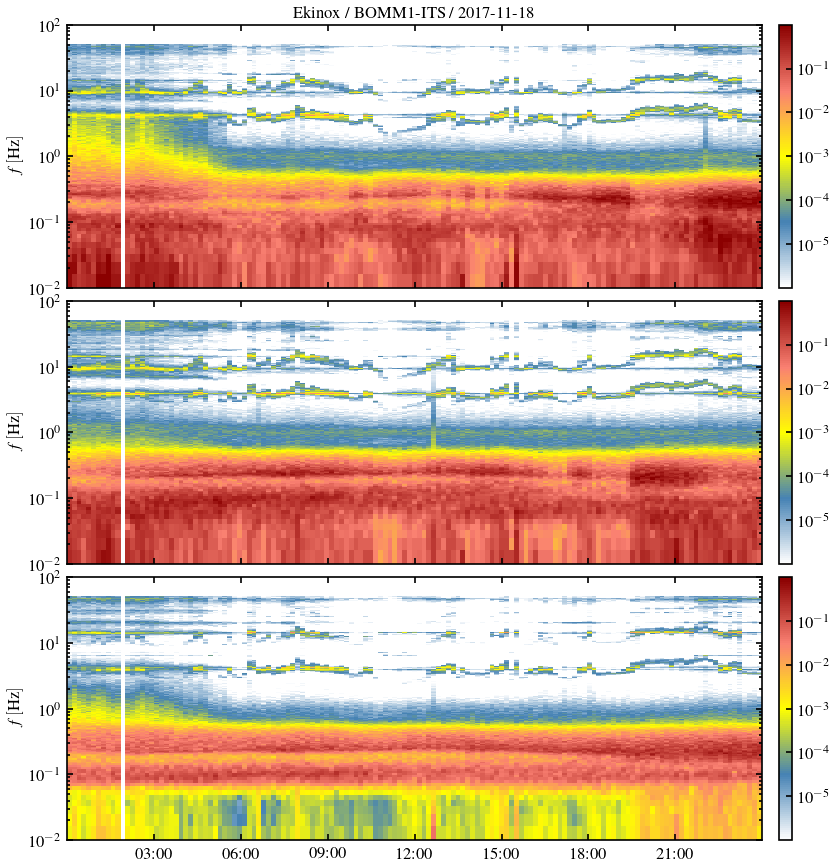

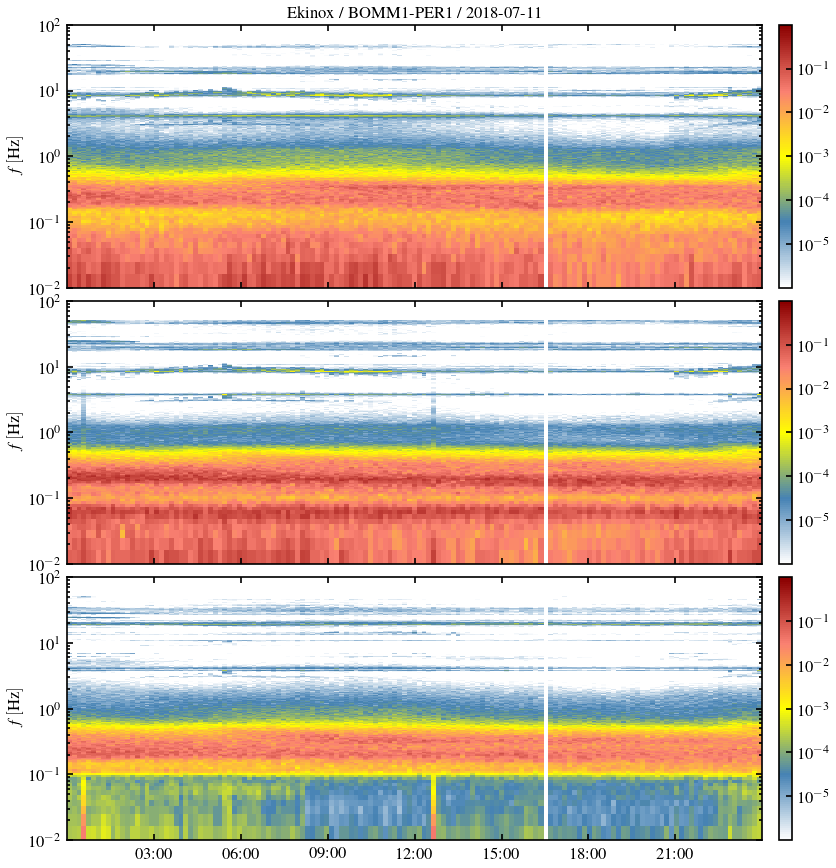

In [3]:
def compute_spectrum(data):
    """Return the time varying spectrum"""
    
    N = 100*600 # ten minutes at 100 Hz
    start, end = 0, N
    num = int(len(data) / N)
    
    P = np.zeros((int((N/5)/2+1), num))
    for i in range(num):
        frq, P[:,i] = signal.welch(data[start:end], fs=100, nperseg=N/5)
        start, end = end, end + N
    
    return np.linspace(0, 24, num), frq, P


def plot_acceleration_hovmoller(bomm, date):
    """Plots a time varying power spectrum"""
    
    strdate = date.strftime("%Y%m%d")
    ncfname = f"/Volumes/Boyas/bomm_database/data/{bomm}/level1/{strdate}.nc"
    
    dataset = nc.Dataset(ncfname, "r")
    time, frq, Px = compute_spectrum(dataset["ekinox"]["accel_x"])
    time, frq, Py = compute_spectrum(dataset["ekinox"]["accel_y"])
    time, frq, Pz = compute_spectrum(dataset["ekinox"]["accel_z"])
    
    colors = ["white", "steelblue", "yellow", "salmon", "darkred"]
    cmap = mcolors.LinearSegmentedColormap.from_list('cmap', colors, N=128)
    
    fig, ax = plt.subplots(3, 1, figsize=(9,9), sharex=True, sharey=True, dpi=120)
    fig.subplots_adjust(hspace=0.05)
    
    pc = ax[0].pcolormesh(time, frq[1:], np.log10(Px[1:,:]), vmin=-6, vmax=0, cmap=cmap)
    pc = ax[1].pcolormesh(time, frq[1:], np.log10(Py[1:,:]), vmin=-6, vmax=0, cmap=cmap)
    pc = ax[2].pcolormesh(time, frq[1:], np.log10(Pz[1:,:]), vmin=-6, vmax=0, cmap=cmap)
    
    ax[0].set_title(f"Ekinox / {bomm.upper().replace('_', '-')} / {date.strftime('%Y-%m-%d')}")
    
    for i in range(3):
        cb = fig.colorbar(pc, ax=ax[i], ticks=[-5,-4,-3,-2,-1], pad=0.02)
        cb.set_ticklabels([f"$10^{{{k}}}$" for k in cb.get_ticks()])
        ax[i].set_xticks(np.arange(3,24,3))
        ax[i].xaxis.set_major_formatter(plt.FormatStrFormatter('%02d:00'))
        ax[i].set_yscale("log")
        ax[i].set_ylim((1E-2, 1E2))
        ax[i].set_ylabel("$f\,\mathrm{[Hz]}$")

# "https://ieeexplore.ieee.org/document/1151908"
plot_acceleration_hovmoller("bomm1_its",  dt.datetime(2017,11,17,0,0))
plot_acceleration_hovmoller("bomm1_its",  dt.datetime(2017,11,18,0,0))
plot_acceleration_hovmoller("bomm1_per1", dt.datetime(2018,7,11,0,0))

## Comparación con otras fuentes

A continuación se hace una comparación de las señales de la aceleración registradas con el `ekinox` con otras fuentes como el IMU (_Inertial Motion Unit_) del `vector` y el acelerometro del `signature`. Particularmente, este último presenta problemas en el muestreo, ya que registra ocho valores por segundo, pero sólo se actualiza cada 1 s, lo que genera una efecto como de cuadrícula, y picos espúreos de energía en el espectro.

### Aceleración lineal

En primer lugar, se hace una comparación de la aceleración lineal registrada por los tres sensores.

In [4]:
metafile = "../metadata/bomm1_per1.yml"
date = dt.datetime(2018,7,11,0,0)

#metafile = "../metadata/bomm1_its.yml"
#date = dt.datetime(2017,11,17,0,0)

r = ReadRawData(metafile)
ekx = r.ekinox(date)
sig = r.signature(date)
vec = r._readfile("vector", date, r._getcolumns("vector"))
bomm = f"{r.metadata['name'].replace('_', '-').upper()}"

# get accelerations from ekinox
acc_ekx = (ekx["accel_x"], ekx["accel_y"], ekx["accel_z"])

# rotate signature into ekinox frame of reference
acc_sig = (sig["accel_x"]/1000, sig["accel_y"]/1000, sig["accel_z"]/1000)
acc_sig_rot = motcor.vector_rotation(acc_sig, (180, -17, 0), units='deg')

# vector ---> page 25: https://www.nrel.gov/docs/fy16osti/62979.pdf
acc_vec = (vec["delta_vel_x"]*1000, vec["delta_vel_y"]*1000, vec["delta_vel_z"]*1000)
acc_vec_rot = motcor.vector_rotation(acc_vec, (0, 0, 180), units='deg')


(736886.0, 736886.0011574074)

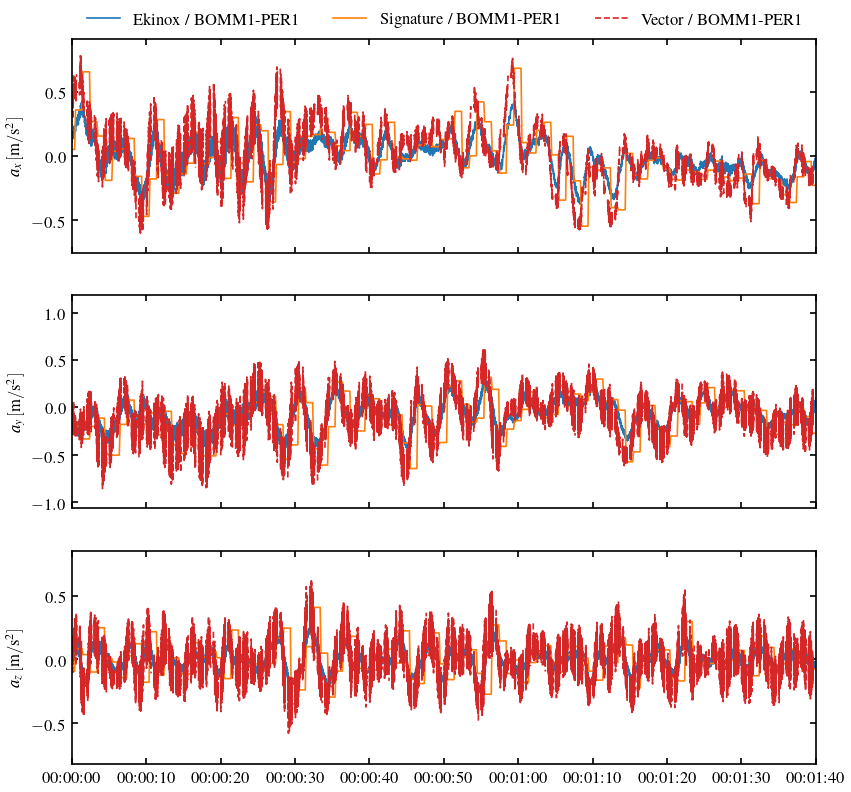

In [5]:
d = lambda x: x-np.nanmean(x)

fig, ax = plt.subplots(3, figsize=(8,8), sharex=True, sharey=False, dpi=120)
#
ax[0].plot(ekx["time"], d(acc_ekx[0]))
ax[1].plot(ekx["time"], d(acc_ekx[1]))
ax[2].plot(ekx["time"], d(acc_ekx[2]))
#
ax[0].plot(sig["time"], d(acc_sig_rot[0]))
ax[1].plot(sig["time"], d(acc_sig_rot[1]))
ax[2].plot(sig["time"], d(acc_sig_rot[2]))
#
ax[0].plot(vec["time"], d(acc_vec_rot[0]), '--')
ax[1].plot(vec["time"], d(acc_vec_rot[1]), '--')
ax[2].plot(vec["time"], d(acc_vec_rot[2]), '--')
#
ax[0].legend((f"Ekinox / {bomm}", f"Signature / {bomm}", f"Vector / {bomm}"),
             loc=2, ncol=3, bbox_to_anchor=(0,1.2))
ax[0].set_ylabel("$a_x\,\mathrm{[m/s^2]}$");
ax[1].set_ylabel("$a_y\,\mathrm{[m/s^2]}$");
ax[2].set_ylabel("$a_z\,\mathrm{[m/s^2]}$");
#ax[2].set_xlabel("Tiempo")
ax[2].set_xlim((ekx["time"][0], ekx["time"][10000]))


### Ángulos de inclincación

Se calcularon los ángulos de inclinación de la boya (_roll_ y _pitch_) usando las señales de cada acelerómetro de acuerdo con las siguientes ecuaciones

$$
\phi = \tan^{-1} \left[ \frac{a_y}{\sqrt{a_x^2 + a_z^2}} \right],
$$

y

$$
\theta = \tan^{-1} \left[ \frac{-a_x}{\sqrt{a_y^2 + a_z^2}} \right].
$$



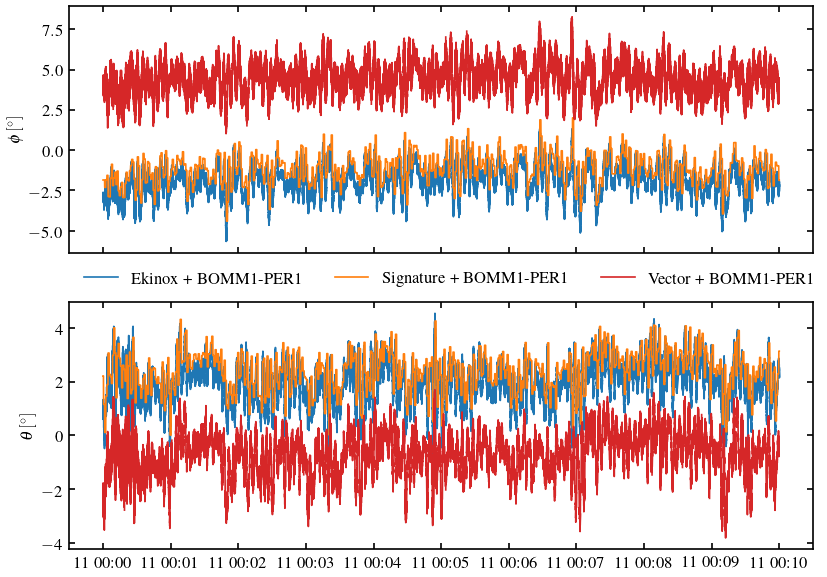

In [6]:
fig, ax = plt.subplots(2, figsize=(8,6), sharex=True, sharey=False, dpi=120)

roll_ekx, pitch_ekx = motcor.tilt_from_accerometer(*acc_ekx)
roll_sig, pitch_sig = motcor.tilt_from_accerometer(*acc_sig_rot)
roll_vec, pitch_vec = motcor.tilt_from_accerometer(*acc_vec_rot)
#
ax[0].plot(ekx["time"], roll_ekx*180/np.pi, label=f"Ekinox + {bomm}")
ax[0].plot(sig["time"], roll_sig*180/np.pi, label=f"Signature + {bomm}")
ax[0].plot(vec["time"], roll_vec*180/np.pi, label=f"Vector + {bomm}")
ax[0].set_ylabel("roll")
ax[0].legend(loc=3, ncol=3, bbox_to_anchor=(0,-.2))
#
ax[1].plot(ekx["time"], pitch_ekx*180/np.pi, label="Ekinox")
ax[1].plot(sig["time"], pitch_sig*180/np.pi, label="Signature")
ax[1].plot(vec["time"], pitch_vec*180/np.pi, label="Vector")
ax[1].set_ylabel("pitch")

ax[0].set_ylabel("$\phi\,\mathrm{[{}^\circ]}$");
ax[1].set_ylabel("$\\theta\,\mathrm{[{}^\circ]}$");

#acc_ekx[2].mean(), acc_sig_rot[2].mean(), acc_vec_rot[2].mean()


## Cálculo de la elevación de la superficie libre

Nos referimos a los movimientos lineales de la boya como las traslaciones que se presentan en las tres direcciones, es decir, la traslación hacia adelante y atrás (surge), la traslación lateral (sway) y la traslación vertical (heave). En este caso se deben integrar las aceleraciones que son registradas por el IMU, una vez para obtener la velocidad y dos veces para obtener la posición. Al igual que al integrar los datos del giroscopio para obtener una estimación la de la inclinación de la boya, se presenta una acumulación del error cuando se integran los datos del acelerómetro, y esto se hace mucho más evidente cuando se integra por segunda vez para obtener la posición. Hay varias alternativas para solucionar este problema, la más sencilla es aprovechar las propiedades de la transformada de Fourier y se hace una integración en el dominio de la frecuencia, removiendo el ruido en las bajas frecuencias. La transformada de Fourier de una serie de tiempo $x(t)$ se podría definir como:

$$
\mathcal{F}\{x(t)\} = X(\omega) = \int x(t) e^{-i\omega t} \mathrm{d}t,
$$

por lo tanto, la doble integral es,

$$
\iint x(t)\mathrm{d}t = \mathcal{F}^{-1} \{(-i\omega)^{-2} X(\omega) \}.
$$

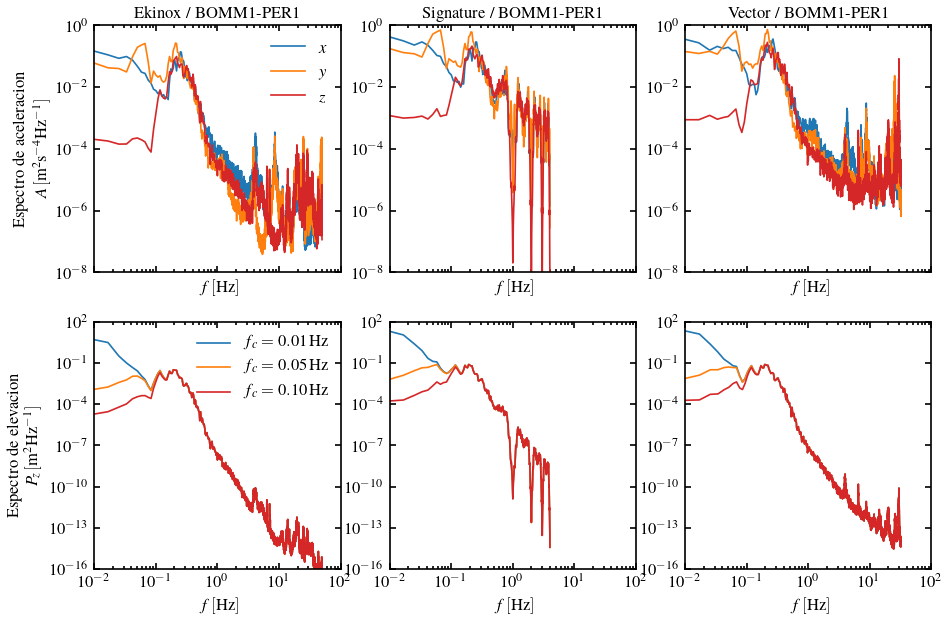

In [14]:
fig, ax = plt.subplots(2, 3, figsize=(9,6), sharex=True, sharey=False, dpi=120)

# clean nans
clean = lambda x: x[~np.isnan(x)]

# acceleration spectra
for i in [0,1,2]:
    
    frq_ekx, A_ekx = signal.welch(clean(acc_ekx[i]), fs=100, nperseg=len(acc_ekx[i])/5)
    frq_sig, A_sig = signal.welch(clean(acc_sig_rot[i]), fs=8, nperseg=len(acc_sig_rot[i])/5)
    frq_vec, A_vec = signal.welch(clean(acc_vec_rot[i]), fs=64, nperseg=len(acc_vec_rot[i])/5)

    ax[0][0].loglog(frq_ekx, A_ekx)
    ax[0][1].loglog(frq_sig, A_sig)
    ax[0][2].loglog(frq_vec, A_vec)

# elevation spectra
for i, fc in enumerate([0.01, 0.05, 0.1]):

    pos_ekx = motcor.fft_integration(clean(acc_ekx[2]), 100, fc=fc, order=-2)
    pos_sig = motcor.fft_integration(clean(acc_sig_rot[2]), 8, fc=fc, order=-2)
    pos_vec = motcor.fft_integration(clean(acc_vec_rot[2]), 64, fc=fc, order=-2)
    
    frq_ekx, P_ekx = signal.welch(pos_ekx, fs=100, nperseg=len(pos_ekx)/5)
    frq_sig, P_sig = signal.welch(pos_sig, fs=8,   nperseg=len(pos_sig)/5)
    frq_vec, P_vec = signal.welch(pos_vec, fs=64,  nperseg=len(pos_vec)/5)
    
    ax[1][0].loglog(frq_ekx, P_ekx)
    ax[1][1].loglog(frq_sig, P_sig)
    ax[1][2].loglog(frq_vec, P_vec)
    #
    ax[1][i].set_xlabel("$f\,\mathrm{[Hz]}$")
    ax[1][i].set_xlim((1E-2, 1E2))
    ax[1][i].set_ylim((1E-16, 1E2))
    #
    ax[0][i].set_xlim((1E-2, 1E2))
    ax[0][i].set_ylim((1E-8, 1E0))
    ax[0][i].set_xlabel("$f\,\mathrm{[Hz]}$")

ax[0][0].set_ylabel("Espectro de aceleracion\n$A\,\mathrm{[m^2s^{-4}Hz^{-1}]}$")
ax[1][0].set_ylabel("Espectro de elevacion\n$P_z\,\mathrm{[m^2Hz^{-1}]}$")
ax[0][0].set_title(f"Ekinox / {bomm}")
ax[0][1].set_title(f"Signature / {bomm}")
ax[0][2].set_title(f"Vector / {bomm}")

ax[0][0].legend(("$x$", "$y$", "$z$"), loc=0)
ax[1][0].legend([f"$f_c={fc}\,\mathrm{{Hz}}$" for fc in ("0.01", "0.05", "0.10")], loc=0)

#fig.savefig("/Users/danielsantiago/Desktop/aceleromtro2.png", dpi=600)

## Efecto de la rotación de la aceleración

Se va a analizar el efecto que tiene aplicar la rotación del sistema de coordendas _BOYA_ al sistema de coordenadas _TIERRA_ de los datos de acelearación. Se evaluará si es más conveniente rotar antes de integrar o viceversa. 

Text(0,0.5,'$z\\;\\mathrm{[m]}$')

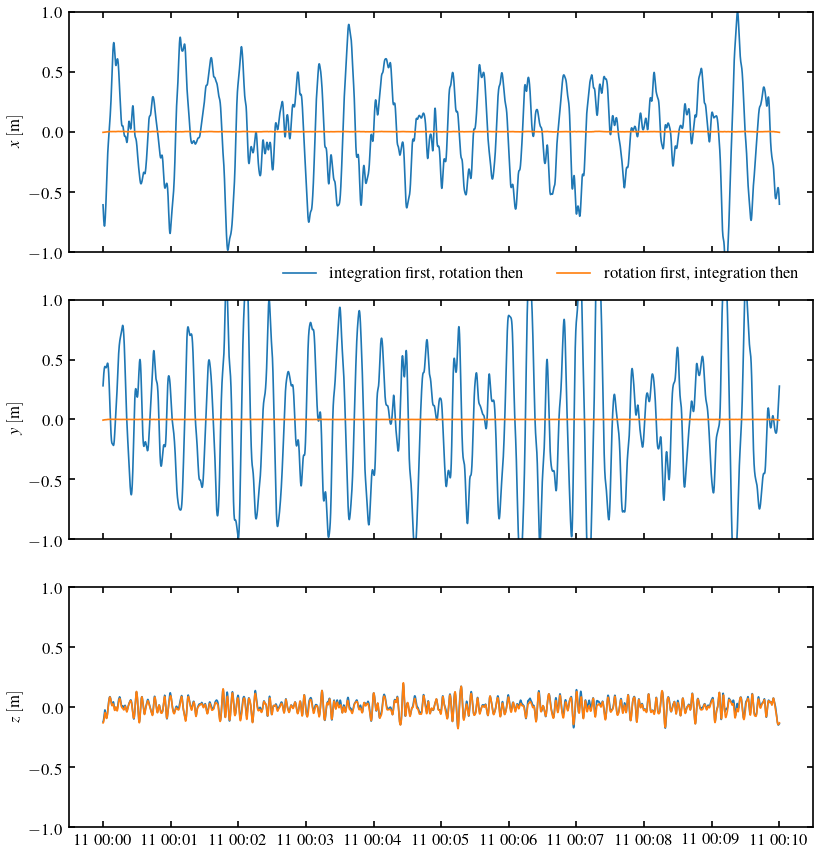

In [8]:
# compute quaternion to perform rotation
gyr_ekx = (ekx["gyro_x"], ekx["gyro_y"], ekx["gyro_z"])
roll, pitch = motcor.pitch_and_roll(*acc_ekx, *gyr_ekx, fs=100, fc=0.1, fm=1)
quaternion = motcor.euler_to_quaternions((roll, pitch, 0))
rotate = lambda x: motcor.quaternion_rotation(x, quaternion, mode="frame")

# rotate acceleromter data before integration
acc_ekx_rot = rotate(acc_ekx)

# integrate with and without rotation
pos_ekx =  rotate(tuple(motcor.fft_integration(a, 100, fc=0.05, order=-2) for a in acc_ekx))
pos_ekx_rot = tuple(motcor.fft_integration(a, 100, fc=0.05, order=-2) for a in acc_ekx_rot)

fig, ax = plt.subplots(3, 1, figsize=(8,9), sharex=True, sharey=False, dpi=120)
for i in [0,1,2]:
    #
    # integration first, rotation then
    ax[i].plot(ekx["time"], pos_ekx[i], label="integration first, rotation then")
    #
    # rotation first, integration then
    ax[i].plot(ekx["time"], pos_ekx_rot[i], label="rotation first, integration then")
    #
    # fix yscale
    ax[i].set_ylim((-1,1))

ax[0].legend(loc=1, ncol=2, bbox_to_anchor=(1,0))
ax[0].set_ylabel("$x\;\mathrm{[m]}$")
ax[1].set_ylabel("$y\;\mathrm{[m]}$")
ax[2].set_ylabel("$z\;\mathrm{[m]}$")